<a href="https://colab.research.google.com/github/khovincent/AutoBrandID/blob/main/new_staticdata_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Setup, Drive Mount, and Data Preparation ---
import os
import shutil
import zipfile
from google.colab import drive

print("--- Mounting Google Drive ---")
drive.mount('/content/drive', force_remount=True)

# Install necessary libraries quietly
!pip install split-folders -q
import splitfolders

--- Mounting Google Drive ---
Mounted at /content/drive


In [ ]:
print("\n--- Preparing Data Directories ---")
# Define file and folder paths
zip_path = '/content/drive/MyDrive/Pertamina/fuel_data/augmentation.zip'
source_data_folder = 'augmented_data'
output_split_folder = 'split_data'
models_folder = 'models'

# Clean up any old directories from previous runs to ensure a fresh start
if os.path.exists(source_data_folder): shutil.rmtree(source_data_folder)
if os.path.exists(output_split_folder): shutil.rmtree(output_split_folder)
os.makedirs(models_folder, exist_ok=True)

# Unzip the data from Google Drive to the fast local Colab disk
print(f"Unzipping '{os.path.basename(zip_path)}' to the local session...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')

# Split the freshly unzipped data into training, validation, and test sets
print(f"Splitting '{source_data_folder}' into train/val/test sets...")
splitfolders.ratio(source_data_folder, output=output_split_folder, seed=1337, ratio=(.8, .1, .1))
print("Data preparation complete.")


--- Preparing Data Directories ---
Unzipping 'augmentation.zip' to the local session...
Splitting 'augmented_data' into train/val/test sets...


Copying files: 67807 files [00:12, 5600.05 files/s]

Data preparation complete.



--- Class Distribution Analysis ---
Total samples in training set: 54244
Samples per class:
  pertalite: 22060 samples (40.67%)
  pertamax: 18103 samples (33.37%)
  pertamaxturbo: 14081 samples (25.96%)


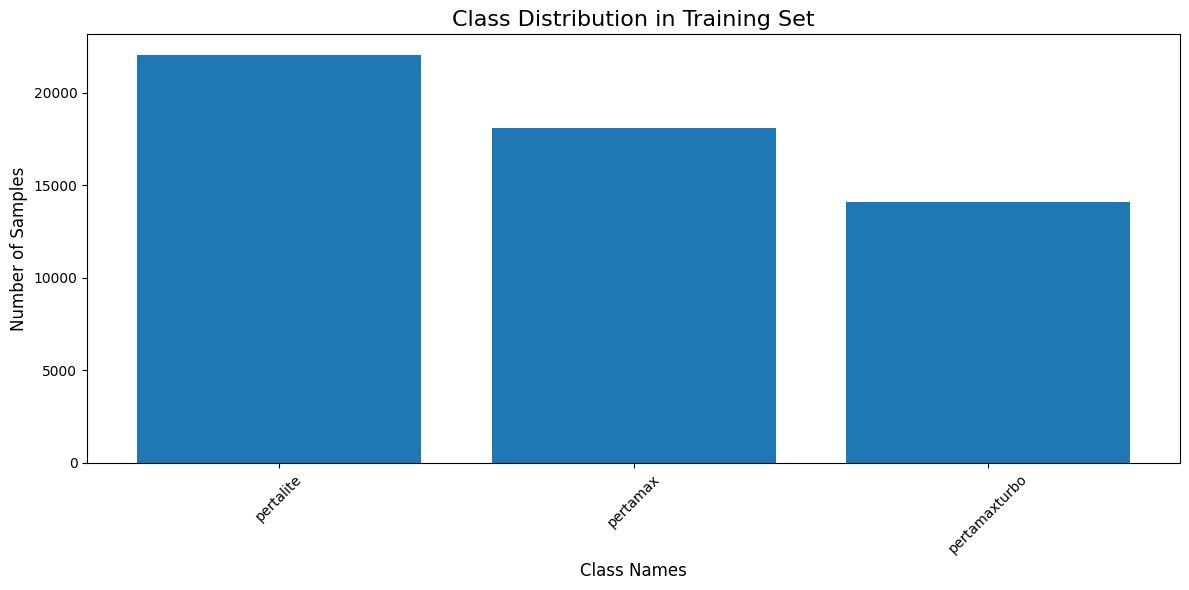

In [ ]:
# --- Visualize Data & Class Distribution ---
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# Create a temporary dataset for visualization and class distribution
train_dir = 'split_data/train'

# Get class names and count samples per class
class_names = sorted(os.listdir(train_dir))
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}
total_samples = sum(class_counts.values())

print("\n--- Class Distribution Analysis ---")
print(f"Total samples in training set: {total_samples}")
print("Samples per class:")
for class_name, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  {class_name}: {count} samples ({percentage:.2f}%)")

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_names, [class_counts[class_name] for class_name in class_names])
plt.title('Class Distribution in Training Set', fontsize=16)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Found 54244 files belonging to 3 classes.


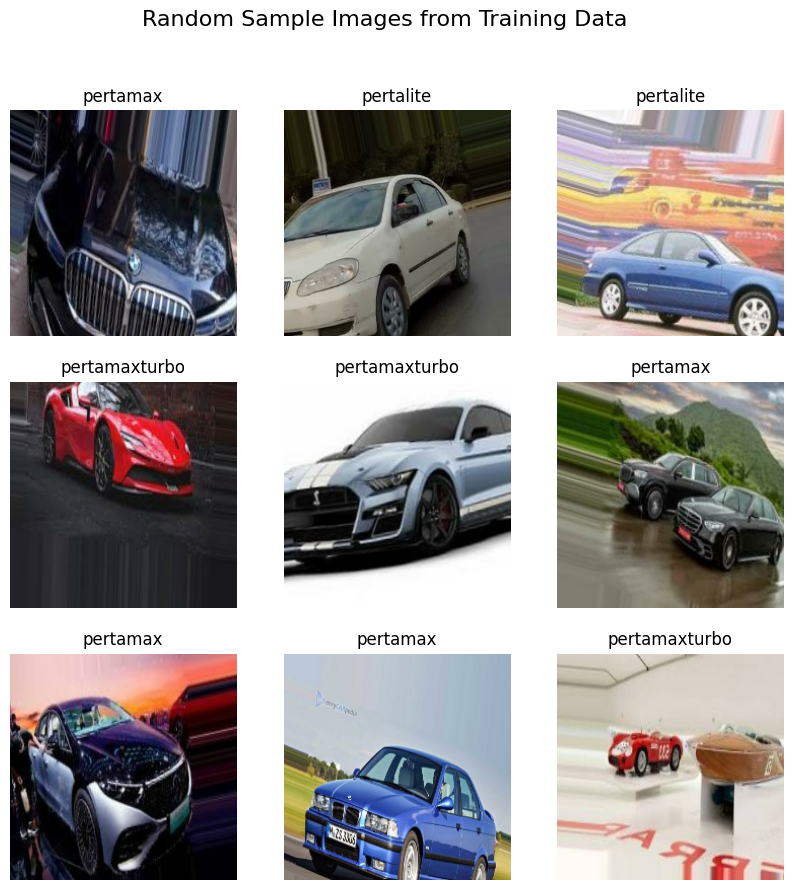

In [ ]:
# Create a temporary dataset for visualization
temp_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=9,
    label_mode='categorical',
    shuffle=True,
    seed=1337
)

# Plot a grid of 9 sample images
plt.figure(figsize=(10, 10))
for images, labels in temp_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Random Sample Images from Training Data", fontsize=16)
plt.show()

In [ ]:
# --- Data Pipeline with Augmentation ---
BATCH_SIZE = 128
IMG_SIZE = (224, 224) # Native size for EfficientNetB0
train_dir = 'split_data/train'
val_dir = 'split_data/val'
test_dir = 'split_data/test'

def create_dataset(directory, is_training=False):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    return dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Creating optimized data pipelines with augmentation...")
train_dataset = create_dataset(train_dir, is_training=True)
validation_dataset = create_dataset(val_dir)
test_dataset = create_dataset(test_dir)
print("Pipelines created.")

Creating optimized data pipelines with augmentation...
Found 54244 files belonging to 3 classes.
Found 6779 files belonging to 3 classes.
Found 6784 files belonging to 3 classes.
Pipelines created.


In [ ]:
# --- Calculate Class Weights for Imbalance Handling ---
print("\n--- Calculating Class Weights for Imbalance Handling ---")
# Get all training labels
train_labels = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    train_labels.extend([class_name] * len(os.listdir(class_dir)))

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights calculated:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weights_dict[i]:.4f}")


--- Calculating Class Weights for Imbalance Handling ---
Class weights calculated:
  pertalite: 0.8196
  pertamax: 0.9988
  pertamaxturbo: 1.2841


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Re-build Model with a More Robust, Regularized Head ---
print("--- Building model with regularized head ---")
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Keep the pre-trained base frozen

# --- REGULARIZED CLASSIFICATION HEAD ---
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x) # A moderate initial dropout

# Main dense block designed to reduce overfitting
x = tf.keras.layers.Dense(512, use_bias=False)(x) # 1. Less complex Dense layer
x = tf.keras.layers.BatchNormalization()(x)      # 2. Batch Normalization for stability
x = tf.keras.layers.Activation('relu')(x)        # 3. Activation function
x = tf.keras.layers.Dropout(0.5)(x)              # 4. Aggressive Dropout after the dense block

# Output Layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the new model summary to see the changes
model.summary()

# --- Define Callbacks with Tuned Patience ---
os.makedirs('models', exist_ok=True)

# ModelCheckpoint saves the absolute best model
checkpoint_path = "models/initial_training_best_regularized.keras" # New name for the checkpoint file
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# EarlyStopping with our tuned patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, # TUNED based on your previous run
    verbose=1,
    restore_best_weights=True
)

# ReduceLROnPlateau will decrease the learning rate if training plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 5
    patience=2, # Reduce LR if no improvement for 2 epochs
    verbose=1,
    min_lr=1e-6
)

--- Building model with regularized head ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,708,518 (17.96 MB)

 Trainable params: 657,923 (2.51 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

In [ ]:
# --- Start Initial Training with the New Head and Callbacks ---
print("\n--- Starting Stage 1: Feature Extraction with Regularized Head and Tuned Callbacks ---")
# Set a higher epoch count; the callbacks will stop it when it's done.
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=[model_checkpoint, early_stopping, reduce_lr] # Use all three callbacks
)
print("\n--- Stage 1 Training Complete ---")


--- Starting Stage 1: Feature Extraction with Regularized Head and Tuned Callbacks ---
Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5804 - loss: 0.9663
Epoch 1: val_loss improved from inf to 0.66267, saving model to models/initial_training_best_regularized.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 145s 266ms/step - accuracy: 0.5805 - loss: 0.9660 - val_accuracy: 0.6973 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 2/50
423/424 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6658 - loss: 0.7257
Epoch 2: val_loss improved from 0.66267 to 0.63409, saving model to models/initial_training_best_regularized.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.6658 - loss: 0.7257 - val_accuracy: 0.7140 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 3/50
423/424 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6821 - loss: 0.6948
Epoch 3: val_loss improved from 0.63409 to 0.60633, saving model to models/initial_training_best_regularized.keras
424/424 ━━━━━━━━━━━━━

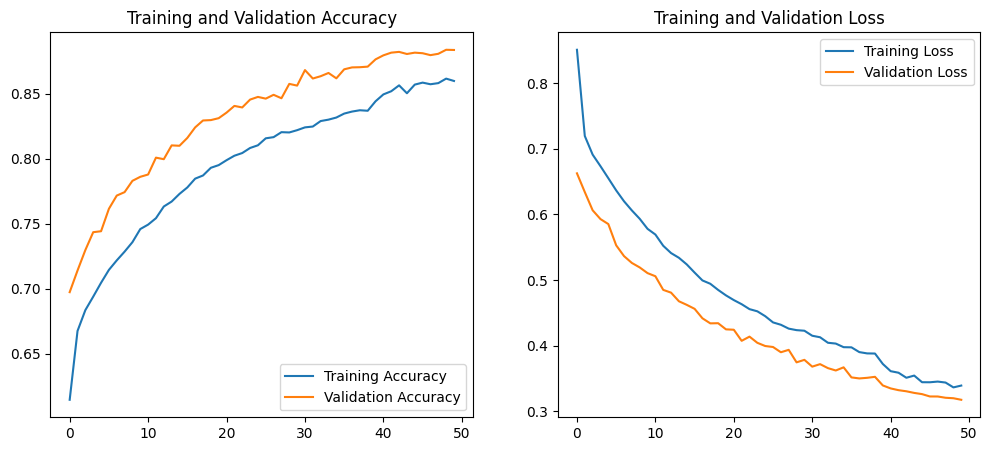

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Plot Training History ---
# Check if training history exists
if 'accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
else:
    print("No training history to plot.")

In [ ]:
# --- Analyze F1-Score and Confusion Matrix on Validation Data ---
print("\n--- Analyzing Performance on Validation Set after Initial Training ---")

# Get true labels and predicted labels for the entire validation set
# The 'model' object has the best weights due to the callbacks
val_labels_categorical = np.concatenate([y for x, y in validation_dataset], axis=0)
val_labels = np.argmax(val_labels_categorical, axis=1)

val_pred_probs = model.predict(validation_dataset)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Calculate per-class F1-scores
print("\n--- Per-Class F1-Scores (Validation Set) ---")
f1_scores = f1_score(val_labels, val_pred_labels, average=None)
for i, class_name in enumerate(class_names):
    print(f"{class_name}: F1-score = {f1_scores[i]:.4f}")

# Calculate the overall F1-score
f1 = f1_score(val_labels, val_pred_labels, average='weighted')
print(f"\nOverall Weighted F1-Score on Validation Set: {f1:.4f}")

# Print the detailed classification report
print("\n--- Classification Report (Validation Set) ---")
print(classification_report(val_labels, val_pred_labels, target_names=class_names))


--- Analyzing Performance on Validation Set after Initial Training ---
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step

--- Per-Class F1-Scores (Validation Set) ---
pertalite: F1-score = 0.8981
pertamax: F1-score = 0.8452
pertamaxturbo: F1-score = 0.9101

Overall Weighted F1-Score on Validation Set: 0.8835

--- Classification Report (Validation Set) ---
               precision    recall  f1-score   support

    pertalite       0.90      0.89      0.90      2757
     pertamax       0.85      0.84      0.85      2262
pertamaxturbo       0.89      0.93      0.91      1760

     accuracy                           0.88      6779
    macro avg       0.88      0.89      0.88      6779
 weighted avg       0.88      0.88      0.88      6779



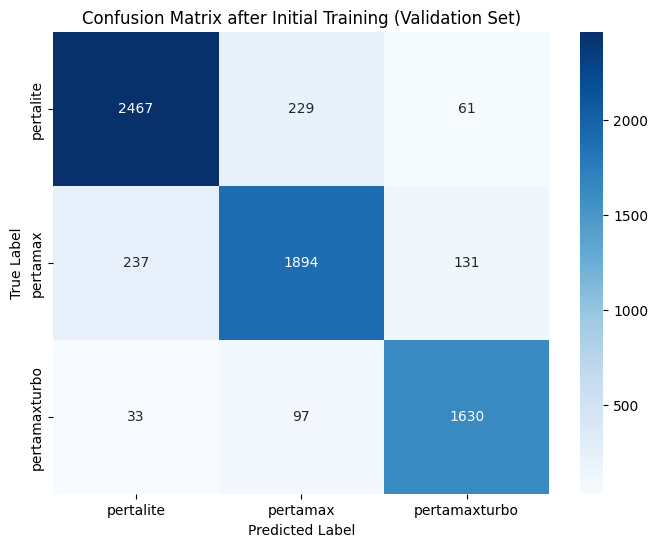

In [ ]:
# Create and display the confusion matrix heatmap
cm = confusion_matrix(val_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix after Initial Training (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# --- Unfreeze the Top Layers of the Base Model ---
base_model = model.get_layer('efficientnetb0')
base_model.trainable = True

# Let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# We will fine-tune from this layer onwards. Unfreezing the top 30 is a good start.
fine_tune_at = len(base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Fine-tuning will start from layer {fine_tune_at} onwards.")

# --- Re-compile the Model with a Very Low Learning Rate ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print the model summary again to see the new ratio of trainable vs. non-trainable parameters
model.summary()

Number of layers in the base model: 238
Fine-tuning will start from layer 208 onwards.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,708,518 (17.96 MB)

 Trainable params: 2,154,083 (8.22 MB)

 Non-trainable params: 2,554,435 (9.74 MB)

In [ ]:
print("\n--- Starting Stage 2: Fine-Tuning Training ---")

# --- Fine-Tuning Stage ---
fine_tune_epochs = 50
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs

# Add the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # The metric to monitor
    factor=0.2,         # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,        # Lower bound on the learning rate
    verbose=1           # Set to 1 to see updates
)

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Start from the epoch after the last one
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=[
        ModelCheckpoint(
            filepath='models/fine_tuning_best.keras',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        reduce_lr
    ]
)
print("\n--- Fine-Tuning Complete ---")


--- Starting Stage 2: Fine-Tuning Training ---
Epoch 51/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6579 - loss: 0.8968
Epoch 51: val_loss improved from inf to 0.52467, saving model to models/fine_tuning_best.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 76s 112ms/step - accuracy: 0.6579 - loss: 0.8966 - val_accuracy: 0.7770 - val_loss: 0.5247 - learning_rate: 1.0000e-05
Epoch 52/100
423/424 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7049 - loss: 0.7371
Epoch 52: val_loss improved from 0.52467 to 0.48793, saving model to models/fine_tuning_best.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.7049 - loss: 0.7370 - val_accuracy: 0.7947 - val_loss: 0.4879 - learning_rate: 1.0000e-05
Epoch 53/100
423/424 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7314 - loss: 0.6492
Epoch 53: val_loss improved from 0.48793 to 0.45815, saving model to models/fine_tuning_best.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.7315 - loss: 0.6491 - val_accuracy: 0.81

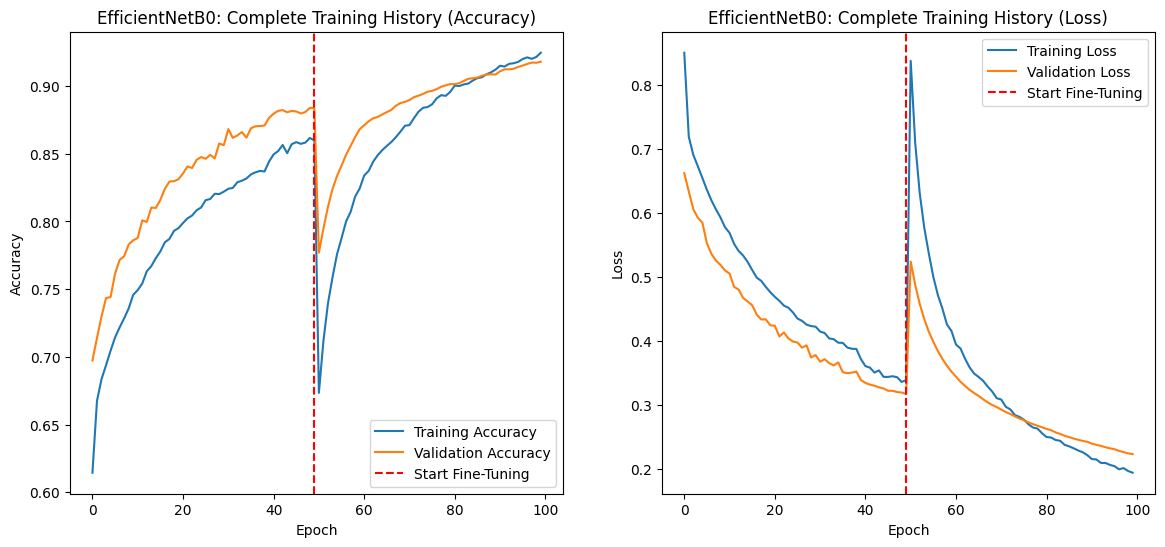

Loading best fine-tuned model from: models/fine_tuning_best.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Combine and Plot the Entire Training History ---

# Combine the history objects
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
total_epochs_trained = len(acc)
epochs_range = range(total_epochs_trained)

# Plot the combined history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(x=len(history.history['accuracy']) - 1, color='red', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('EfficientNetB0: Complete Training History (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(x=len(history.history['loss']) - 1, color='red', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('EfficientNetB0: Complete Training History (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# --- Evaluate Final Model on the Test Set with F1-Score ---

# load the best model saved during fine-tuning
best_model_path = 'models/fine_tuning_best.keras'
if os.path.exists(best_model_path):
    print(f"Loading best fine-tuned model from: {best_model_path}")
    model = tf.keras.models.load_model(best_model_path)

In [ ]:
print("\n--- Evaluating Final Model on the Unseen Test Dataset ---")
final_loss, final_accuracy = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Test Loss: {final_loss:.4f}")

# --- Generate Final Classification Report (including F1-Score) ---

# Get the true labels and predicted labels for the entire test set
test_labels_categorical = np.concatenate([y for x, y in test_dataset], axis=0)
test_labels = np.argmax(test_labels_categorical, axis=1)

test_pred_probs = model.predict(test_dataset)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Calculate per-class F1-scores on test set
print("\n--- Per-Class F1-Scores (Test Set) ---")
test_f1_scores = f1_score(test_labels, test_pred_labels, average=None)
for i, class_name in enumerate(class_names):
    print(f"{class_name}: F1-score = {test_f1_scores[i]:.4f}")

# Calculate the overall F1-score
f1 = f1_score(test_labels, test_pred_labels, average='weighted')
print(f"Overall Weighted F1-Score on Test Set: {f1:.4f}")

# Print the detailed classification report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(test_labels, test_pred_labels, target_names=class_names))


--- Evaluating Final Model on the Unseen Test Dataset ---
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9219 - loss: 0.2172
Final Test Accuracy: 92.10%
Final Test Loss: 0.2183
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step

--- Per-Class F1-Scores (Test Set) ---
pertalite: F1-score = 0.9285
pertamax: F1-score = 0.8977
pertamaxturbo: F1-score = 0.9386
Overall Weighted F1-Score on Test Set: 0.9208

--- Classification Report (Test Set) ---
               precision    recall  f1-score   support

    pertalite       0.93      0.93      0.93      2759
     pertamax       0.91      0.89      0.90      2264
pertamaxturbo       0.93      0.95      0.94      1761

     accuracy                           0.92      6784
    macro avg       0.92      0.92      0.92      6784
 weighted avg       0.92      0.92      0.92      6784



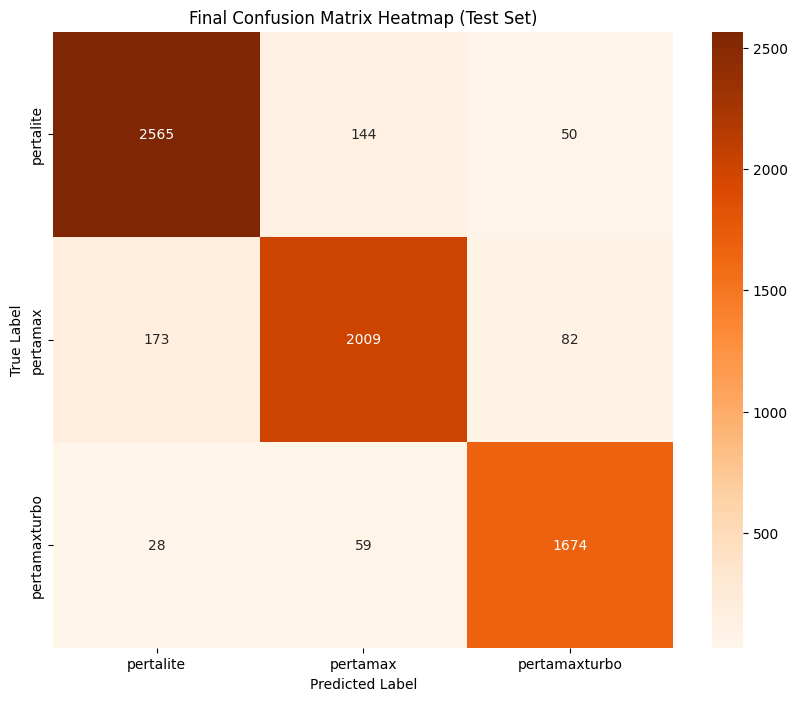

In [ ]:
# --- Display the Final Confusion Matrix Heatmap ---
cm_final = confusion_matrix(test_labels, test_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix Heatmap (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Generating ROC Curves for Multiclass Classification ---


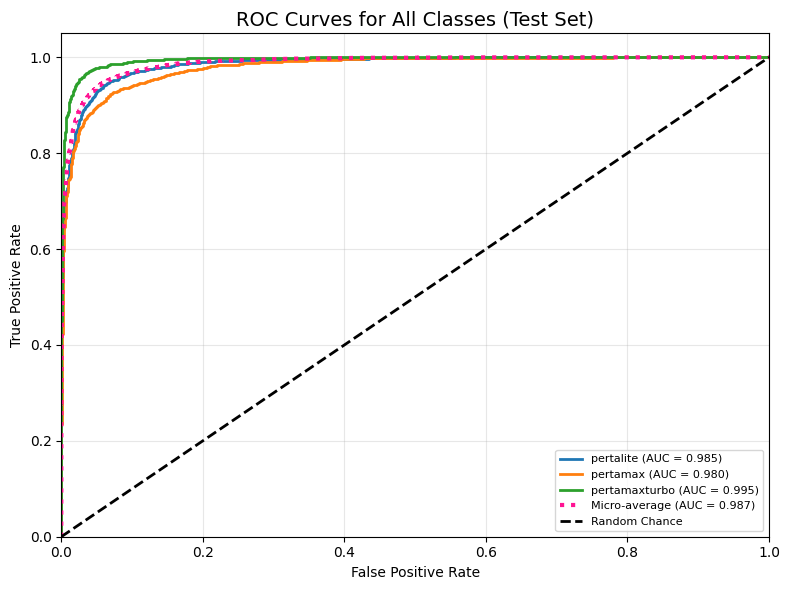


--- AUC Scores per Class (Test Set) ---
pertalite: AUC = 0.9853
pertamax: AUC = 0.9795
pertamaxturbo: AUC = 0.9945
Micro-average AUC: 0.9872


In [ ]:
# --- ROC Curve for Multiclass Classification ---
print("\n--- Generating ROC Curves for Multiclass Classification ---")

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for ROC calculation
n_classes = len(class_names)
y_test_bin = label_binarize(test_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), test_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curves for All Classes (Test Set)', fontsize=14)
plt.legend(loc="lower right", fontsize=8) # Smaller font for legend
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("\n--- AUC Scores per Class (Test Set) ---")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: AUC = {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")

QUALITATIVE ANALYSIS: UNDERSTANDING MODEL BEHAVIOR
 Found 32 incorrect predictions out of 500 samples (6.40%)


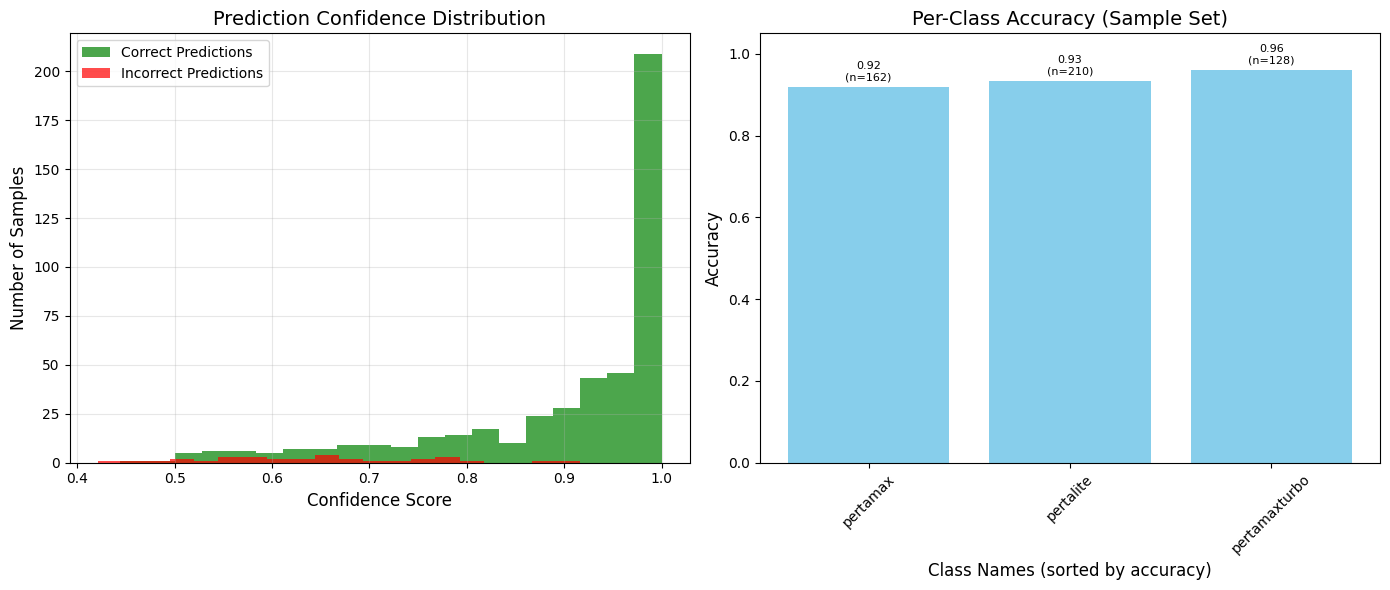


 Key Observations from Qualitative Analysis:
--------------------------------------------------
1. Overall accuracy on sample set: 93.60%
2. Average confidence on correct predictions: 0.9018
3. Average confidence on incorrect predictions: 0.6458
4. Total incorrect predictions: 32
5. Classes with lowest accuracy: ['pertamax', 'pertalite', 'pertamaxturbo']
6. Classes with highest confidence on errors: ['pertalite', 'pertamax', 'pertamax']

 Found 3 HIGH-CONFIDENCE MISCLASSIFICATIONS (confidence > 0.8)
These cases indicate systematic errors in model understanding:
   • True: pertalite → Predicted: pertamax (Confidence: 81.43%)
     Top predictions: pertamax: 81.43% pertalite: 17.91% pertamaxturbo: 0.66% 
   • True: pertamax → Predicted: pertalite (Confidence: 86.95%)
     Top predictions: pertalite: 86.95% pertamax: 13.04% pertamaxturbo: 0.00% 
   • True: pertamax → Predicted: pertalite (Confidence: 91.63%)
     Top predictions: pertalite: 91.63% pertamax: 6.82% pertamaxturbo: 1.54% 


In [ ]:
# --- Qualitative Analysis - Model Behavior Deep Dive ---
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
import json
from pathlib import Path
import random

print("QUALITATIVE ANALYSIS: UNDERSTANDING MODEL BEHAVIOR")

# Get a subset of test data for qualitative analysis
sample_size = 500
test_sample_images = []
test_sample_labels = []
test_sample_probs = []

# Collect samples
for images, labels in test_dataset.take(sample_size // BATCH_SIZE + 1):
    preds = model.predict(images, verbose=0)
    for i in range(len(images)):
        if len(test_sample_images) < sample_size:
            test_sample_images.append(images[i].numpy())
            test_sample_labels.append(tf.argmax(labels[i]).numpy())
            test_sample_probs.append(preds[i])

# Convert to numpy arrays for easier handling
test_sample_images = np.array(test_sample_images)
test_sample_labels = np.array(test_sample_labels)
test_sample_probs = np.array(test_sample_probs)

# Identify correct and incorrect predictions
predicted_labels = np.argmax(test_sample_probs, axis=1)
is_correct = (predicted_labels == test_sample_labels)
confidence = np.max(test_sample_probs, axis=1)

# Count incorrect predictions
num_incorrect = np.sum(~is_correct)
print(f" Found {num_incorrect} incorrect predictions out of {sample_size} samples ({num_incorrect/sample_size:.2%})")

# Analyze confidence distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(confidence[is_correct], bins=20, alpha=0.7, label='Correct Predictions', color='green')
if num_incorrect > 0:
    plt.hist(confidence[~is_correct], bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Prediction Confidence Distribution', fontsize=14)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Analyze per-class performance
plt.subplot(1, 2, 2)
class_accuracy = []
class_counts = []

for i, class_name in enumerate(class_names):
    class_mask = (test_sample_labels == i)
    class_count = np.sum(class_mask)
    class_counts.append(class_count)

    if class_count > 0:
        class_acc = np.mean(is_correct[class_mask])
        class_accuracy.append(class_acc)
    else:
        class_accuracy.append(0)

# Sort classes by accuracy for better visualization
sorted_indices = np.argsort(class_accuracy)
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_accuracy = [class_accuracy[i] for i in sorted_indices]
sorted_counts = [class_counts[i] for i in sorted_indices]

bars = plt.bar(range(len(sorted_class_names)), sorted_accuracy, color='skyblue')
plt.title('Per-Class Accuracy (Sample Set)', fontsize=14)
plt.xlabel('Class Names (sorted by accuracy)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(len(sorted_class_names)), sorted_class_names, rotation=45)
plt.ylim(0, 1.05)

# Add value labels on top of bars and sample counts
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = sorted_counts[i]
    plt.annotate(f'{height:.2f}\n(n={count})',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Show challenging examples analysis
print("\n Key Observations from Qualitative Analysis:")
print("-" * 50)
print(f"1. Overall accuracy on sample set: {np.mean(is_correct):.2%}")
print(f"2. Average confidence on correct predictions: {np.mean(confidence[is_correct]):.4f}")
if num_incorrect > 0:
    print(f"3. Average confidence on incorrect predictions: {np.mean(confidence[~is_correct]):.4f}")
    print(f"4. Total incorrect predictions: {num_incorrect}")

    # Safely get classes with lowest accuracy
    lowest_acc_indices = np.argsort(class_accuracy)[:min(3, len(class_names))]
    lowest_acc_classes = [class_names[i] for i in lowest_acc_indices]
    print(f"5. Classes with lowest accuracy: {lowest_acc_classes}")

    # Safely get classes with highest confidence on errors
    if num_incorrect >= 3:
        error_confidences = confidence[~is_correct]
        error_indices = np.where(~is_correct)[0]
        top_error_indices = error_indices[np.argsort(error_confidences)[-3:]]
        top_error_classes = [class_names[test_sample_labels[i]] for i in top_error_indices]
        print(f"6. Classes with highest confidence on errors: {top_error_classes}")
    elif num_incorrect > 0:
        error_indices = np.where(~is_correct)[0]
        error_classes = [class_names[test_sample_labels[i]] for i in error_indices]
        print(f"6. Classes with errors (all): {error_classes}")
    else:
        print("6. No errors found for analysis")
else:
    print("3. No incorrect predictions found in sample set!")
    print("4. Model achieved perfect accuracy on this sample!")
    print("5. All classes performed well on this sample set")

# Find most confidently misclassified examples (only if errors exist)
if num_incorrect > 0:
    confident_errors = np.where((~is_correct) & (confidence > 0.8))[0]
    print(f"\n Found {len(confident_errors)} HIGH-CONFIDENCE MISCLASSIFICATIONS (confidence > 0.8)")

    if len(confident_errors) > 0:
        print("These cases indicate systematic errors in model understanding:")
        for idx in confident_errors[:min(5, len(confident_errors))]:
            true_class = class_names[test_sample_labels[idx]]
            pred_class = class_names[predicted_labels[idx]]
            conf = confidence[idx]
            print(f"   • True: {true_class} → Predicted: {pred_class} (Confidence: {conf:.2%})")

            # Show probability distribution for this error
            top_probs = np.argsort(test_sample_probs[idx])[-3:][::-1]  # Top 3 probabilities
            print(f"     Top predictions: ", end="")
            for prob_idx in top_probs:
                class_prob = class_names[prob_idx]
                prob_value = test_sample_probs[idx][prob_idx]
                print(f"{class_prob}: {prob_value:.2%} ", end="")
            print()
    else:
        print("No high-confidence errors found. Most errors have low confidence, indicating model uncertainty.")
else:
    print("\n Perfect performance on sample set - no errors to analyze!")

VISUAL ERROR ANALYSIS: EXAMINING MISCLASSIFICATIONS
 Top 5 Classes with Most Misclassifications:
--------------------------------------------------
pertalite: 14 misclassifications (6.7% error rate)
pertamax: 13 misclassifications (8.0% error rate)
pertamaxturbo: 5 misclassifications (3.9% error rate)


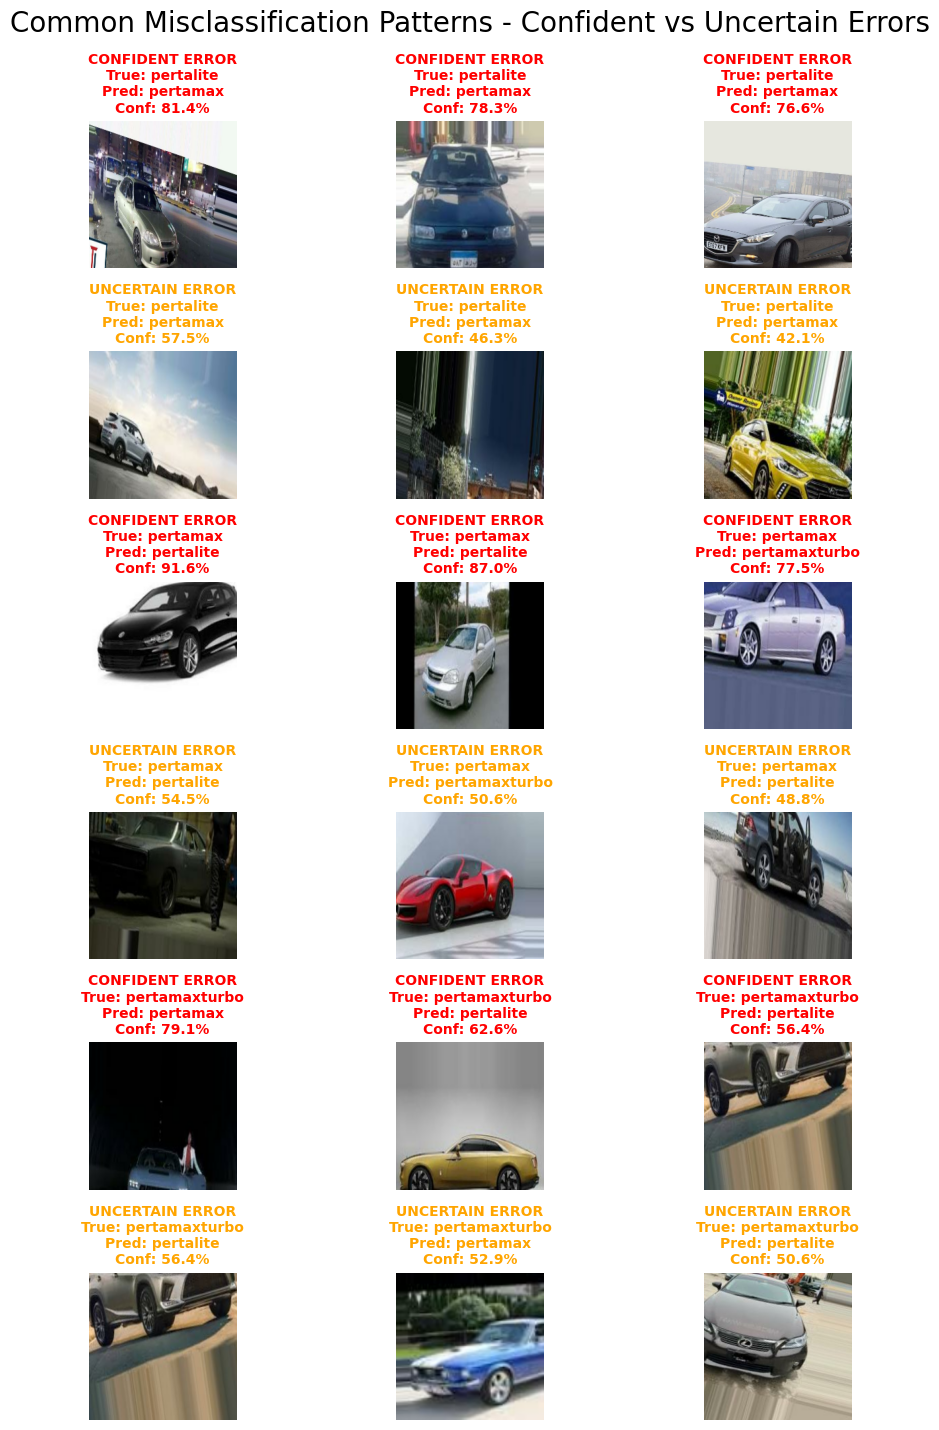


 Common Misclassification Pairs:
--------------------------------------------------
pertalite → pertamax: 14 times
pertamax → pertalite: 10 times
pertamax → pertamaxturbo: 3 times
pertamaxturbo → pertalite: 3 times
pertamaxturbo → pertamax: 2 times


In [37]:
# --- Visual Error Analysis - Understanding Failure Modes ---
print("VISUAL ERROR ANALYSIS: EXAMINING MISCLASSIFICATIONS")

# Get top misclassifications by class
misclassifications = {}
for i in range(len(class_names)):
    misclassifications[i] = []

# Collect misclassified examples with metadata
for idx in range(len(test_sample_images)):
    if not is_correct[idx]:
        true_label = test_sample_labels[idx]
        pred_label = predicted_labels[idx]
        conf = confidence[idx]
        misclassifications[true_label].append({
            'image': test_sample_images[idx],
            'true_label': true_label,
            'pred_label': pred_label,
            'confidence': conf,
            'prob_vector': test_sample_probs[idx]
        })

# Find classes with most misclassifications
class_error_counts = {i: len(errors) for i, errors in misclassifications.items()}
sorted_classes = sorted(class_error_counts.items(), key=lambda x: x[1], reverse=True)

print(" Top 5 Classes with Most Misclassifications:")
print("-" * 50)
for class_idx, count in sorted_classes[:5]:
    class_name = class_names[class_idx]
    print(f"{class_name}: {count} misclassifications ({count/len(test_sample_labels[test_sample_labels==class_idx]):.1%} error rate)")

# Visualize common misclassification patterns
plt.figure(figsize=(10, 15))
plot_idx = 1

# Show top 3 problematic classes
for rank, (class_idx, count) in enumerate(sorted_classes[:3]):
    class_name = class_names[class_idx]
    errors = misclassifications[class_idx]

    if not errors:
        continue

    # Sort errors by confidence (highest first)
    errors.sort(key=lambda x: x['confidence'], reverse=True)

    # Get top 3 confident errors and top 3 uncertain errors
    confident_errors = errors[:3]
    uncertain_errors = errors[-3:]

    # Plot confident errors (model was sure but wrong)
    for j, error in enumerate(confident_errors):
        plt.subplot(6, 3, plot_idx)
        img = error['image'].astype("uint8")
        plt.imshow(img)
        true_name = class_names[error['true_label']]
        pred_name = class_names[error['pred_label']]
        conf = error['confidence']
        plt.title(f"CONFIDENT ERROR\nTrue: {true_name}\nPred: {pred_name}\nConf: {conf:.1%}",
                 color='red', fontweight='bold', fontsize=10)
        plt.axis('off')
        plot_idx += 1

    # Plot uncertain errors (model was unsure)
    for j, error in enumerate(uncertain_errors):
        plt.subplot(6, 3, plot_idx)
        img = error['image'].astype("uint8")
        plt.imshow(img)
        true_name = class_names[error['true_label']]
        pred_name = class_names[error['pred_label']]
        conf = error['confidence']
        plt.title(f"UNCERTAIN ERROR\nTrue: {true_name}\nPred: {pred_name}\nConf: {conf:.1%}",
                 color='orange', fontweight='bold', fontsize=10)
        plt.axis('off')
        plot_idx += 1

plt.suptitle('Common Misclassification Patterns - Confident vs Uncertain Errors', fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create confusion matrix for error types
print("\n Common Misclassification Pairs:")
error_pairs = {}
for true_class, errors in misclassifications.items():
    for error in errors:
        pair = (true_class, error['pred_label'])
        error_pairs[pair] = error_pairs.get(pair, 0) + 1

# Sort by frequency
sorted_pairs = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)

print("-" * 50)
for (true_idx, pred_idx), count in sorted_pairs[:10]:
    true_name = class_names[true_idx]
    pred_name = class_names[pred_idx]
    print(f"{true_name} → {pred_name}: {count} times")